A fine-tuned language model for pictionary word list completion (topic/category phrase + example words -> list of 30 examples). For example, one may complete the list

"A list of round fruits: peach, apricot, lime, plum,"

with

"mango, cherry, pineapple, strawberry, pumpkin, watermelon, orange, pomegranate, melon, apple, pear, grapefruit, papaya, lemon, kiwi, passionfruit, blueberry, raspberry, blackberry, cantaloupe, nectarine, pitaya, persimmon, durian, guava, jackfruit, avocado, lychee, soursop, guarana, mangosteen, blackcurrant, cranberry"

using this model. These words should be compatible with pictionary/skribbl.io; i.e., "sketchable" within a few minutes, and easily recognisable. Scroll to the end for more examples, or see the file `data/examples.txt`. Sketchability parameter estimation examples can also be found in `data/data.tsv`.

In [1]:
import os
import openai

In [2]:
with open('../../openai-api-org.txt', 'r') as f:
    openai.organization = f.read()
with open('../../openai-api-key.txt', 'r') as f:
    openai.api_key = f.read()

In [3]:
import csv
import time
import string
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import GPT2ForSequenceClassification, GPT2LMHeadModel, ReformerModelWithLMHead, \
                         get_linear_schedule_with_warmup
from pytorch_transformers import GPT2Tokenizer
from transformers import GPT2TokenizerFast
from Learning import *

I0831 01:27:37.583227 51340 modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I0831 01:27:37.595196 51340 modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Complete.


In [4]:
   ###   Options   ###

model_name = "ernst_one"
# gpt2_modelkey = "gpt2"               # Pretrained model to start from
gpt2_modelkey = "gpt2-xl"            # Pretrained model to start from
test_set_frac = 0.25                 # Fraction of samples to keep as separate test set (word lists)
sample_test_n = 200                  # Number of randomly generated prompts for each sample when validating model
log_period_batches = 10               # Batches per iteration
# learning_rate = 5e-7                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
learning_rate = 7e-5                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
# learning_rate = 4e-6                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
adam_epsilon = 1e-8                  # Adam epsilon (default is 1e-8)
n_sched_warmup = 0                   # Linear scheduler for optimizer number of warmup steps
# batch_size = bsz = 8                 # Samples per batch
batch_size = bsz = 64                # Samples per batch
# batch_size = bsz = 128                # Samples per batch
N_train_batches = int(1e7 / bsz)     # Total number of batches to show model
min_nw, max_nw = 0.7, 0.9            # Minimum and maximum fraction of list to keep when truncating
max_listlen = 15                     # Maximum number of words in the list when creating a prompt (at least prior to * max_nw)
lidstone_e = 0.01                    # Smoothing for possible words/subwords which are not in the missing list words set
max_len = 96                         # Max n. tokens specified in order to match a power of 2, applied prior to *max_nw (tokens)
lastcomma_repl = ',' # 'EOS', ','    # Token optionally used to replace the final comma that ends the generated phrase
use_correct_nouns = True             # Whether to use only correct singular or plural form of category nouns for the given prompt
swap_noun = False                    # Whether to swap plural and singular nouns in prompt (diversity)

In [5]:
dev = "cuda" if pt.cuda.is_available() else "cpu"
d = device = pt.device(dev)
# world_size = 1
# rank = 0
# def setup(rank, world_size): 
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = find_free_port()
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)  # initialize the process group
# def cleanup():
#     dist.destroy_process_group()
# # mp.spawn(setup, args=(rank, world_size), nprocs=world_size)
# setup(rank, world_size)

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained(gpt2_modelkey.replace("-xl", "-large"), padding=True)

I0831 01:27:43.117554 51340 tokenization_utils.py:384] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-large-vocab.json from cache at C:\Users\alfew\.cache\torch\pytorch_transformers\69f8d734111f39eaa51a85907bfdc81a7ef42242d638ffab6f77df305402b2b2.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
I0831 01:27:43.118551 51340 tokenization_utils.py:384] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-large-merges.txt from cache at C:\Users\alfew\.cache\torch\pytorch_transformers\38d28acc17953e356348dca948e152c653c0ccf5058a552eea30168e27f02046.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


In [7]:
gpt3_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2-large"), padding=True)

In [8]:
cats, cats_sing, phrases = Listset().load()  # Import word lists dataset

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    tokenizer.encode("A list of round fruits: apples,"), \
    tokenizer.encode("oranges, pears,")
gpt3_tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    gpt3_tokenizer.encode("A list of round fruits: apples,"), \
    gpt3_tokenizer.encode("oranges, pears,")

In [7]:
lprompts_encoded = [[tokenizer.encode(prompt), "types of" in prompt] for prompt in lprompts]
cats_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e = [[tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
comma_token = pt.tensor(tokenizer.encode(",")[0], device=d)
lprompts_encoded3 = [[gpt3_tokenizer.encode(prompt), "types of" in prompt] for prompt in lprompts]
cats_e3 = [[gpt3_tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e3 = [[gpt3_tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e3 = [[gpt3_tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
comma_token3 = pt.tensor(gpt3_tokenizer.encode(",")[0], device=d)
N_tokens = len(tokenizer)
N_wordlists = len(cats)

In [8]:
lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
lprompts_sing = [(prmpt, typesof) for (prmpt, typesof) in lprompts_encoded if typesof ^ swap_noun]
lprompts_encoded3 = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded3]
cats_e3 = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e3]
cats_sing_e3 = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e3]
phrases_e3 = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e3]
lprompts_sing3 = [(prmpt, typesof) for (prmpt, typesof) in lprompts_encoded3 if typesof ^ swap_noun]
# N_tokens = pt.tensor(N_tokens, device=d)
# max_len = pt.tensor(max_len, device=d)
# bsz = pt.tensor(batch_size, device=d)
# lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
# cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
# cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
# phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
# N_tokens = pt.tensor(N_tokens, device=d)
# max_len = pt.tensor(max_len, device=d)
# bsz = pt.tensor(batch_size, device=d)
lidstone_e = pt.tensor(lidstone_e, device=d)
lid_val = lidstone_e / N_tokens
y_zero = (lid_val).repeat(N_tokens)

In [9]:
# Generate a fixed test set and save to disk, using nw_draw = 15. This function defines the next list token prediction problem
def gen_truncated_list(prmt, p):  # prmt = prompt tokens, p = list word/phrase tokens
    tkzs, sent, tkix = [], [], 0
    max_ws = max_len - len(prmt)
#     incl_words = pt.randperm(len(p))[:min(max_listlen, len(p))]
    incl_words = np.random.choice(len(p), min(max_listlen, len(p)), replace=False)
    for phz_i in incl_words:
        phz_enc = p[phz_i]
        tkzs.append((tkix, phz_enc))
        tkix += len(phz_enc)
        sent.append(phz_enc)
        if tkix >= max_ws:
            tkix = max_ws
            break
    sent = pt.hstack(sent)[:max_ws]
    missing_w = [p[i] for i in range(len(p)) if i not in incl_words]
    trunc_ix = np.random.randint(round(tkix * min_nw), round(tkix * max_nw))
    trunc_n = min([(trunc_ix - ix) for (ix, enc) in tkzs if ix <= trunc_ix])  # N. end phrase tokens
    missing_w += [enc for (ix, enc) in tkzs if ix >= (trunc_ix - trunc_n)]
    missing_matches = missing_w
    if trunc_n > 0:
        phr_start = trunc_ix - trunc_n
        partial_phr = sent[phr_start:trunc_ix]
        missing_matches = [enc for enc in missing_w if len(enc) >= trunc_n and all(enc[:trunc_n] == partial_phr)]
    next_tokens = [enc[trunc_n] for enc in missing_matches]
    norm = len(next_tokens) * (1.0 + lidstone_e)
    tunit, y_ = pt.tensor(1 / norm, device=d), y_zero.clone()
    for token in next_tokens: y_[token] += tunit
    return pt.hstack([prmt, sent[:trunc_ix]]), y_
def gen_samples_uniform(xcp, xcs, xp, nw, prompt=None, verbose=False):  # Weight testing samples (word lists) uniformly
    xs, ys, sqlens, j, prmt = [], [], [], 0, None
    if prompt is not None: prmt = pt.tensor(tokenizer.encode(prompt), device=d)
    for i in range(len(xcp)):
        x, y, sqlen = [], [], []
        cp, cs, p = xcp[i], xcs[i], xp[i]
        cp_cs = cp + cs
        for m in range(nw):
#             prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
#             cat_ix = np.random.randint(len(cp))
#             x_, y_ = gen_truncated_list(pt.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
            cat_ix = np.random.randint(len(cp_cs))  # First uniformly sample a category title
            sing = cat_ix >= len(cp)
            if prompt is None:
                lprmpts = lprompts_sing if sing else lprompts_encoded
                prmt, _ = lprmpts[np.random.randint(len(lprmpts))]
            x_, y_ = gen_truncated_list(pt.hstack([prmt, cp_cs[cat_ix]]), p)
            x.append(x_)
            y.append(y_)
            sqlen.append(len(x_))
            j += 1
            if verbose and j % 100 == 0:
                sys_print("\rDone: " + str(j))
        xs.append(x)
        ys.append(y)
        sqlens.append(sqlen)
    if verbose: sys_print("\rDone: " + str(j) + ", finished!\n")
    return xs, ys, sqlens
def gen_samples(xcp, xcs, xp, n, prompt=None):  # Maximise training batch diversity by randomly sampling the word lists
    xs, ys, sqlens, j, prmt = [], [], [], 0, None
    if prompt is not None: prmt = pt.tensor(tokenizer.encode(prompt), device=d)
    xs, ys, sqlens, j = [], [], [], 0
    n_sets = len(xcp)
    for m in range(n):
        i = np.random.randint(n_sets)
        cp, cs, p = xcp[i], xcs[i], xp[i]
        cp_cs = cp + cs
        cat_ix = np.random.randint(len(cp_cs))  # First uniformly sample a category title
        sing = cat_ix >= len(cp)
        if prompt is None:
            lprmpts = lprompts_sing if sing else lprompts_encoded
            prmt, _ = lprmpts[np.random.randint(len(lprmpts))]
        x_, y_ = gen_truncated_list(pt.hstack([prmt, cp_cs[cat_ix]]), p)
        xs.append(x_)
        ys.append(y_)
        sqlens.append(len(x_))
    return xs, ys, sqlens

In [10]:
N_test = int(test_set_frac * N_wordlists)
N_train = N_wordlists - N_test
test_idx = np.random.choice(N_wordlists, N_test, replace=False)
save_ld(test_idx, "test.data")
# test_idx = load_ld("test.data")
# test_idx = np.array([0, 2])  # Round fruits and chemical elements
train_idx = [i for i in range(N_wordlists) if i not in test_idx]
print("Train:")
print([cats[i][0] for i in train_idx])
print("Test:")
print([cats[i][0] for i in test_idx])
cats_e_test, cats_sing_e_test = [cats_e[i] for i in test_idx], [cats_sing_e[i] for i in test_idx]
phrases_e_test = [phrases_e[i] for i in test_idx]
cats_e_train, cats_sing_e_train = [cats_e[i] for i in train_idx], [cats_sing_e[i] for i in train_idx]
phrases_e_train = [phrases_e[i] for i in train_idx]
test_cats = [cats[i][0] for i in test_idx]
test_xs, test_ys, test_sqlens = gen_samples_uniform(cats_e_test, cats_sing_e_test, phrases_e_test, sample_test_n, verbose=True)

Train:
['round fruits', 'wild animals', 'microorganisms', 'music', 'machine learning algorithms', 'outback experiences', 'scientific cycles', 'buildings', 'glassware']
Test:
['hats', 'chemical elements', 'dramatic and literature elements']


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Done: 600, finished!


In [69]:
# write function that takes a prompt, existing list and sampling params and returns gpt3's next token probs
default_msp = {
  "best_of": 1,
}
default_sp = {
  "temperature": 1.0,
  "top_p": 1.0,
  "presence_penalty": 0.0,
  "frequency_penalty": 0.0,
}
default_params = {
  "engine": "davinci",
  "max_tokens": 1,
  "temperature": 1.0,
  "top_p": 1.0,
  "presence_penalty": 0.0,
  "frequency_penalty": 0.0,
  "n": 1,
  "stream": False,
  "logprobs": 100,
#       "logit_bias": {"50256": -100},
  "stop": [",", "\n"],
}
# Define and test the OpenAI API next token probability request (response-token-efficient streaming version)
def p_req(s, **kwargs):
    use_stream = kwargs["max_tokens"] != 1
    kwargs["prompt"], kwargs["stream"] = s, use_stream
    response, result = openai.Completion.create(**{**default_params, {k: kwargs[k] for k in kwargs if k in default_params}}), []
    for resp in response if use_stream else [response]:
        res, r = [], [(np.e**v, k) for (k, v) in resp["choices"][0]["logprobs"]["top_logprobs"][0].items()]
        r.sort(reverse=True)
        for i in range(len(r)):
            k = gpt3_tokenizer.encode(r[i][1])
            if len(k) == 1: res.append((r[i][0], k if kwargs["tokenize"] else r[i][1]))
        result.append(res)
    return result
# todo: version to handle multiple choices
def p_req_multi(s, **kwargs):
    kwargs["prompt"] = s
    response = openai.Completion.create(**{**default_params, {k: kwargs[k] for k in kwargs if k in default_params}})
    for choice in response["choices"]:
#     res, r = [], [(np.e**v, k) for (k, v) in choice["logprobs"]["top_logprobs"][0].items()]
#     r.sort(reverse=True)
#     for i in range(len(r)):
#         k = gpt3_tokenizer.encode(r[i][1])
#         if len(k) == 1: res.append((r[i][0], k if kwargs["tokenize"] else r[i][1]))
#     result.append(res)
a = p_req("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, greenhouse effect,")
# print(sum([a_[0] for a_ in a]))
a, len(a)

I0902 17:15:21.044914 51340 util.py:54] message='Request to OpenAI API' method=post path=https://api.openai.com/v1/engines/davinci/completions
I0902 17:15:21.737567 51340 util.py:54] message='OpenAI API response' path=https://api.openai.com/v1/engines/davinci/completions processing_ms=90 response_code=200


([[(0.12578191562723093, ' peach'),
   (0.10995109532530711, ' orange'),
   (0.06562375038526426, ' pineapple'),
   (0.053508861675627045, ' banana'),
   (0.04946816735558898, ' water'),
   (0.04835120185489226, ' k'),
   (0.04795297192054186, ' mel'),
   (0.04672202958247505, ' grape'),
   (0.03857482952714878, ' lemon'),
   (0.03639382360202449, ' avocado'),
   (0.03206455706937598, ' cherry'),
   (0.02950670362282783, ' pap'),
   (0.02856900185990249, ' plum'),
   (0.02808694503779063, ' etc'),
   (0.018097188215281553, ' strawberry'),
   (0.01779807453012586, ' apr'),
   (0.015615636921467758, ' gu'),
   (0.015189962972513106, ' pear'),
   (0.014377180742190864, ' and'),
   (0.012655238991742472, ' tomato'),
   (0.01009313690970218, ' grapes'),
   (0.008296877830063467, ' cant'),
   (0.008151225458716946, ' p'),
   (0.00797534795932278, ' n'),
   (0.00667984162865372, ' pe'),
   (0.006376407040855265, ' citrus'),
   (0.005721882610679001, ' fig'),
   (0.004615689583405488, ' lime')

In [106]:
response = openai.Completion.create(**{**default_params,
      "prompt": "A list of round fruits: apple, pear, mango,",
      "temperature": 1.5,
      "top_p": 1.0,
      "n": 5,
      "best_of": 20,
      "max_tokens": 7,
      "stop": [",", "\n"],
    })
response

I0902 20:25:33.093925 51340 util.py:54] message='Request to OpenAI API' method=post path=https://api.openai.com/v1/engines/davinci/completions
I0902 20:25:35.180966 51340 util.py:54] message='OpenAI API response' path=https://api.openai.com/v1/engines/davinci/completions processing_ms=500 response_code=200


<OpenAIObject text_completion id=cmpl-3dmd4kaeLvFJMFgsTM7LzClwb2ufM at 0x17a645725c8> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": {
        "text_offset": [
          43,
          48,
          50,
          52,
          54,
          54,
          54
        ],
        "token_logprobs": [
          -4.791866,
          -0.031157045,
          -0.012906361,
          -8.781245e-05,
          -0.107893,
          -1.5558919,
          -0.013262724
        ],
        "tokens": [
          " cant",
          "al",
          "ou",
          "pe",
          ",",
          " water",
          "melon"
        ],
        "top_logprobs": [
          {
            "\n": -6.3985076,
            " &": -8.075002,
            " ...": -7.2703986,
            " Kiw": -8.180298,
            " a": -7.9955516,
            " ac": -7.909921,
            " an": -8.062614,
            " and": -4.2421145,
            " apple": -7.0412383,
            " apr

In [100]:
response["choices"][1]["logprobs"]["top_logprobs"][3]

<OpenAIObject at 0x17a645d8888> JSON: {
  "\n": -3.7609768,
  "\n\n": -5.474535,
  " &": -7.8041725,
  " (": -4.1083393,
  " (\"": -9.873827,
  " +": -10.125095,
  " ,": -7.6815715,
  " -": -7.5959473,
  " --": -9.34741,
  " .": -7.681928,
  " ..": -9.857025,
  " ...": -7.339998,
  " /": -9.089521,
  " 1": -9.931755,
  " =": -9.594738,
  " A": -8.860895,
  " Fruit": -10.175486,
  " How": -10.197649,
  " I": -9.964721,
  " In": -10.076441,
  " Round": -9.868875,
  " The": -8.615159,
  " What": -10.128782,
  " [": -7.9674582,
  " a": -10.10361,
  " all": -8.285897,
  " also": -9.569124,
  " among": -9.804682,
  " and": -3.377222,
  " are": -6.5548306,
  " as": -8.823701,
  " but": -9.125437,
  " can": -8.487028,
  " come": -10.188585,
  " et": -9.513094,
  " etc": -4.8148937,
  " for": -8.9834385,
  " from": -9.974204,
  " fruit": -9.456668,
  " fruits": -9.457527,
  " have": -9.917754,
  " in": -7.932508,
  " is": -9.027098,
  " like": -9.004519,
  " of": -6.7888274,
  " or": -6.180959,

In [108]:
for choice in response["choices"]:
    d = {}
    tokens = choice["logprobs"]["tokens"]
    t_i = -1
    for t in tokens:
        t_i += 1
        r = [(np.e**v, k) for (k, v) in choice["logprobs"]["top_logprobs"][t_i].items()]
        r.sort(reverse=True)
        print(sum([v for (v, k) in r]))
        rd = dict([(k, v) for (v, k) in r])
        r = [k for (v, k) in r]
        d[t] = (rd, r, np.e**choice["logprobs"]["token_logprobs"][t_i])
    print('|'.join([' '.join((s.replace("\n", "⏎"),'%.2f' % (d[s][2] * 100),
                              str(d[s][1].index(s) + 1) if s in d[s][1] else "<100")) for s in tokens]))

0.9743193635720732
0.99984588774178
0.9999004775370296
0.9999937216231087
0.9967845539012515
0.9717827444642915
0.9998804198657992
 cant 0.83 22|al 96.93 1|ou 98.72 1|pe 99.99 1|, 89.77 1| water 21.10 1|melon 98.68 1
0.9743192454271726
0.9997726603363309
0.9999464319929372
0.9924922556139968
0.9255530449622655
0.9931423870638382
0.9195301597212377
 pist 0.01 <100|ach 98.98 1|io 97.18 1|, 81.29 1| coconut 2.09 14|, 81.29 1| pineapple 4.34 6
0.9743192630505474
0.9991013005965053
0.9999730319834664
0.9958955056643286
0.9626761045336414
0.9921613283468388
0.9966267876150103
 honey 0.07 66|d 96.07 1|ew 99.97 1|, 72.95 1| strawberry 1.88 13|⏎ 99.24 1|⏎ 99.24 1
0.9743192454271726
0.9943000803321925
0.9718708107510459
0.9952646528775474
0.9661074834859679
0.9988232611717052
0.9934639169494086
 orange 11.00 2|, 88.59 1| lemon 14.94 1|, 88.59 1| cran 0.14 48|berry 82.60 1|⏎ 4.02 3
0.974319370520433
0.9999079846012271
0.9997355871139249
0.9956105623826133
0.9934313063082408
0.802155135719878
0.95

In [109]:
rezy = openai.Completion.create(**{**default_params,
      "prompt": "A list of round fruits: apple, pear, mango,",
      "temperature": 1.5,
      "top_p": 1.0,
      "n": 5,
      "max_tokens": 7,
      "stop": [",", "\n"],
    })
rezy

I0902 22:12:16.689332 51340 util.py:54] message='Request to OpenAI API' method=post path=https://api.openai.com/v1/engines/davinci/completions
I0902 22:12:18.736418 51340 util.py:54] message='OpenAI API response' path=https://api.openai.com/v1/engines/davinci/completions processing_ms=384 response_code=200


<OpenAIObject text_completion id=cmpl-3doIMXx3omaLGji9kn4S5VpLVQc9C at 0x17a645b6888> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": {
        "text_offset": [
          43,
          47,
          49,
          52,
          56,
          61,
          64
        ],
        "token_logprobs": [
          -11.526833,
          -0.5038978,
          -15.029004,
          -8.184897,
          -9.966224,
          -0.8700079,
          -0.64463645
        ],
        "tokens": [
          " pot",
          "at",
          "ild",
          " all",
          " poly",
          "gon",
          "al"
        ],
        "top_logprobs": [
          {
            "\n": -6.3985076,
            " &": -8.075003,
            " ...": -7.2704005,
            " Kiw": -8.1803,
            " a": -7.9955516,
            " ac": -7.9099236,
            " an": -8.062614,
            " and": -4.242115,
            " apple": -7.0412383,
            " apr": -4.02

In [119]:
# Not sure if these are errors from the API but the unusual completions aren't useful to us anyways
for a_ in a:
    txt = a_[1]
#     if txt[:6] == "bytes:":
#         txt = txt[6:].strip()
    r = gpt3_tokenizer.encode(txt)
    if len(r) > 1:
        print(a_[0], a_[1], gpt3_tokenizer.encode(txt), r)

0.006916793387894473 bytes:\xe2\x80 [33661, 7479, 27705, 17, 59, 87, 1795] [33661, 7479, 27705, 17, 59, 87, 1795]
0.00021436615507941935 bytes: \xe2\x80 [33661, 25, 3467, 27705, 17, 59, 87, 1795] [33661, 25, 3467, 27705, 17, 59, 87, 1795]


In [118]:
# function that takes a completion distribution (top 100) and target next token distribution (multinomial) and computes the
# probability that the completion produces a desired output token
def prob_corr(pred_p, target_p):
    r = 0
    if isinstance(pred_p, list):
        for (p, token) in pred_p:
            if target_p[token] > (lid_val + 1e-10):
                r += p
    else:
        r = np.sum(target_p[np.nonzero(pred_p > (lid_val + 1e-10))[0]])
    return r
# directly computes the similary between target and predicted token distribution
def score_corr(pred_p, target_p, distance="cross-entropy", redistribute_mass=False, include_negatives=False):  
    r = 0
    if isinstance(pred_p, list) and not redistribute_mass:
        for (p, token) in pred_p:
            targ = target_p[token]
            if targ > (lid_val + 1e-10) or include_negatives:
                if distance == "unnormalized":    r -= p * targ
                elif distance == "cross-entropy": r -= p * np.log(targ)
                elif distance == "kl-divergence": r += p * np.log(p / targ)
                elif distance == "bhattacharyya": r += np.sqrt(p * targ)
        if distance == "bhattacharyya": r = -np.log(r)
    else:
        p = pred_p
        if isinstance(pred_p, list):
            p_ = np.asarray([p for (p, _) in pred_p])
            ts = np.asarray([t for (_, t) in pred_p])
            unaccounted_mass = 1.0 - sum(p_)
            n_missing_tokens = N_tokens - len(pred_p)
            p = np.repeat(unaccounted_mass / n_missing_tokens, N_tokens)
            p[ts] = p_
        if not include_negatives:
            pos = np.nonzero(target_p > (lid_val + 1e-10))[0]
            p, target_p = p[pos], target_p[pos]
        if distance == "unnormalized": r = -np.sum(p * targ)
        elif distance == "cross-entropy": r = -np.sum(p * np.log(target_p))
        elif distance == "kl-divergence": r = np.sum(p * np.log(p / target_p))
        elif distance == "bhattacharyya": r = -np.log(np.sum(np.sqrt(p * target_p)))
    return -r

In [ ]:
# function that takes some sampling parameters, then generates n random incomplete list prompts (of length l), obtains completion
# distributions (top 100 tokens or full multinomial) and evaluates the average score across the n prompts. n = 20 by default
# All samples generated are stored fully for later training of sample-dependent sampling parameter (mixture) distribution
def eval_sp(params, min_l=0, max_l=None, n=20, prmt=None, phase="train", uniform=False, model='gpt3'):
    res = []
    tknzr = gpt3_tokenizer if model == "gpt3" else tokenizer
    xcp, xcs, xp = \
      ((cats_e3_test,  cats_sing_e3_test,  phrases_e3_test) if phase == "test" else \
       (cats_e3_train, cats_sing_e3_train, phrases_e3_train)) if model == "gpt3" else \
      ((cats_e_test,  cats_sing_e_test,  phrases_e_test) if phase == "test" else \
       (cats_e_train, cats_sing_e_train, phrases_e_train))
    # use gen_samples_uniform for testing (and training if it works better)
    xs, ys, sqlens = gen_samples_uniform(xcp, xcs, xp, n, prmt=prmt, tokenizer=tknzr) if uniform else \
                     gen_samples        (xcp, xcs, xp, n, prmt=prmt, tokenizer=tknzr)
    if model == 'gpt3':  # Convert tokens to string and request predictions from OpenAI
        xs = xs.detach().cpu().numpy()
        x = [tokenizer.decode(x_) for x_ in xs]
        r = [p_req(x_, **params) for x_ in xs]
        return np.mean([score_corr(r[i], ys[i]) for i in range(len(r))])
    # save subtext example FP info
# This metric differs depending on tokenisation, so for the testing of models, a full phrase accuracy function is required
def test_sp(params, min_l=0, max_l=None, n=20, prmt=None, phase="train", uniform=False, model='gpt3'):
    res = []
    tknzr = gpt3_tokenizer if model == "gpt3" else tokenizer
    xcp, xcs, xp = \
      ((cats_e3_test,  cats_sing_e3_test,  phrases_e3_test) if phase == "test" else \
       (cats_e3_train, cats_sing_e3_train, phrases_e3_train)) if model == "gpt3" else \
      ((cats_e_test,  cats_sing_e_test,  phrases_e_test) if phase == "test" else \
       (cats_e_train, cats_sing_e_train, phrases_e_train))
    # use gen_samples_uniform for testing (and training if it works better)
    xs, ys, sqlens = gen_samples_uniform(xcp, xcs, xp, n, prmt=prmt, tokenizer=tknzr) if uniform else \
                     gen_samples        (xcp, xcs, xp, n, prmt=prmt, tokenizer=tknzr)
    if model == 'gpt3':  # Convert tokens to string and request predictions from OpenAI
        xs = xs.detach().cpu().numpy()
        x = [tokenizer.decode(x_) for x_ in xs]
        r = [p_req(x_, **params) for x_ in xs]
        return np.mean([score_corr(r[i], ys[i]) for i in range(len(r))])
    # save subtext example FP info
eval_sp(default_ps)

In [ ]:
# add example ids to dataset, add subtext 'parent', fix format

In [ ]:
# function that uses bayesian optimisation or similar method to quickly find the maxima of the above function (find best params)

In [ ]:
# do the same above but for the single best_of parameter on phrase completions (secondary phase) once we have the other params

In [ ]:
# function that uses the l argument to do the bayesian optimisation once for each "length group"
lgroups = [[1], [2], [3], [4], [5], [6, 7], [8, 9], [10, 11], [12, 14], [15, 17], [18, 20] [21, 24], [25, 28]] # optimise

In [ ]:
# objective here: use the above for each prompt and figure out the best prompt multinomial (probably still "A list of") for all l
# can also see if random prompt requires more samples to converge, l dependence, and score vs fixed prompt for each l group.
# if it works better, use a random prompt each time; we may benefit if the prompt-dependent vars can be learned.
# also, eventually, we can experiment with choosing a prompt for the query, however this is inherently anti-diversity GUI

In [ ]:
# write 'global evaluator' function that compares the previous two methods using the same code, next token score (and next word?)

In [ ]:
# make a GP/density net/MDN model of length feats (+cond.prob. features) vs sampling params (mt), mu sigma, mixture dist., eps.

In [ ]:
# include gpt2/gpt-neo embeddings (next step gpt3 embeddings (?)) (and see if a mixture distribution is (still) necessary)

In [ ]:
# see if fine-tuning a tertiary post-completion filter phase improves accuracy (aim for as few false negatives as possible)

In [ ]:
# compare with typical one-hot fine-tuning of gpt2, gpt-neo & gpt3 (optimise sampling params & filter)

In [ ]:
# compare with multinomial fine-tuning of gpt2, gpt-neo (next step gpt3 multinomial) (optimise sampling params & filter)

In [ ]:
# use an ensemble of the most successful of the above methods to create candidate outputs, then train a
# joint filter to distinguish between correct and erroneous list completions (gpt2/gpt-neo/gpt3-prompt) (next step gpt3) 0FNs

In [ ]:
# try using the joint filter trained with the ensemble outputs to filter the responses of the best single model from the ensemble

In [11]:
# Define next batch function
def adapt_form(xs, ys, sqlens, repl_finalcomma=True):
    xs = pt.vstack([F.pad(x, (0, max(0, max_len - len(x))), mode='constant', value=pad_token)[:max_len] for x in xs])
    _ys = pt.vstack(ys)
    if repl_finalcomma and (lastcomma_repl != ','):
        _ys[:, repl_token] += _ys[:, comma_token] - lid_val
        _ys[:, comma_token] = lid_val
    return xs, _ys, pt.tensor(sqlens, device=d)
def next_batch(sz):
    global cats_e_train, cats_sing_e_train, phrases_e_train
    return adapt_form(*gen_samples(cats_e_train, cats_sing_e_train, phrases_e_train, sz))

In [12]:
if 'model' in locals():
    del model
pt.cuda.empty_cache()
print(gc.collect())
create_folder("models")
create_folder("models/pretrained")
create_folder("models/pretrained/GPT2LMHead")
# model_ = GPT2ForSequenceClassification.from_pretrained('gpt2-large',
# model_ = GPT2LMHeadModel.from_pretrained('gpt2-xl',
# model_ = GPT2LMHeadModel.from_pretrained('gpt2-large',
# model_ = GPT2LMHeadModel.from_pretrained('gpt2-medium',
model_ = GPT2LMHeadModel.from_pretrained(gpt2_modelkey,
    output_hidden_states=False, output_attentions=False, 
    cache_dir="models/pretrained/GPT2LMHead")
if pt.cuda.device_count() > 1:
    # model_.parallelize()
    device_map = {0: [0, 1, 2],
                  1: [3, 4, 5, 6, 7, 8],
                  2: [9, 10, 11, 12, 13, 14],
                  3: [15, 16, 17, 18, 19, 20],
                  4: [21, 22, 23, 24, 25, 26, 27],
                  5: [28, 29, 30, 31, 32, 33, 34],
                  6: [35, 36, 37, 38, 39, 40, 41],
                  7: [42, 43, 44, 45, 46, 47],
                 }
    # device_map = {0: [0, 1, 2],
    #               1: [3, 4, 5, 6, 7, 8],
    #               2: [9, 10, 11, 12, 13, 14],
    #               3: [15, 16, 17, 18, 19, 20],
    #               4: [21, 22, 23, 24, 25, 26, 27],
    #               5: [28, 29, 30, 31, 32, 33, 34],
    #               6: [35, 36, 37, 38, 39, 40, 41],
    #               7: [42, 43, 44, 45, 46, 47],
    #              }
    model_.parallelize(device_map)
else:
    model_ = model_.to(d)
print("GPT2 device:", model_.device)
model_.resize_token_embeddings(N_tokens)
pad_token = model_.config.pad_token_id = model_.config.eos_token_id
pad_token = pt.tensor(pad_token, device=d)
repl_token = pt.tensor(tokenizer.encode(lastcomma_repl)[0], device=d) if lastcomma_repl != 'EOS' else pad_token
n_embd = pt.tensor(model_.config.n_embd, device=d)
# model = nn.parallel.DistributedDataParallel(model_, device_ids=[d])
# model = nn.DataParallel(
#     model_, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else model_
model = model_
print("Pretrained parameters loaded")
gc.collect()

40
GPT2 device: cuda:0
Pretrained parameters loaded


1271

In [13]:
llayer = None #nn.Linear(n_embd, N_tokens, bias=False).to(d)#.cpu()
# nn.init.xavier_uniform_(llayer.weight)
# llayer = nn.DataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else llayer
# llayer = nn.parallel.DistributedDataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))).to(d)
# softmax = nn.Softmax()
bcewl_loss = nn.BCEWithLogitsLoss()#.to(d)#.cpu()
# bcewl_loss = nn.DataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d) if dev != "cpu" else bcewl_loss
# bcewl_loss = nn.parallel.DistributedDataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d)
# nll_loss = nn.NLLLoss()
# kl_loss = nn.KLDivLoss()
optimizer = pt.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_sched_warmup, num_training_steps=N_train_batches)
def sequence_mask(lengths, maxlen=None, dtype=pt.int):
    if maxlen is None:
        maxlen = lengths.max()
    row_vector = pt.arange(0, maxlen, 1, device=d)
    matrix = pt.unsqueeze(lengths, dim=-1)
    mask = row_vector < matrix

    mask = mask.type(dtype)
    return mask
def train_step():
    global model, llayer, bcewl_loss, optimizer, bsz, scheduler
    x_batch, y_batch, sqlens_batch = next_batch(bsz)

#     for x in x_batch.cpu().detach().numpy():
#         print(tokenizer.decode(x))
    model.zero_grad()
    mask = sequence_mask(sqlens_batch, max_len)
    outputs = model(x_batch.long(), attention_mask=mask)  # Get logits
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens_batch - 1, 1).repeat((1, N_tokens)), 1).type(pt.int64)
    outs = pt.gather(outputs[0], 1, out_idx).squeeze(1)
#     outs = outputs[0][:, -1]
#     logits = llayer(outs)
    logits = outs
    
#     logsofts = pt.log(softmax(logits))
    loss = bcewl_loss(logits, y_batch.float())
    loss = loss.mean()
    correct = pt.mean((y_batch[pt.arange(batch_size), pt.argmax(logits, axis=1)] > (lid_val + 1e-10)).float())
    loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    return loss_, correct_

def inference(x, sqlens):
    global model, llayer

    x, sqlens = x, sqlens
#     for x_ in x.cpu().detach().numpy():
#         print(tokenizer.decode(x_))
    mask = sequence_mask(sqlens, max_len)
    outputs = model(x.long(), attention_mask=mask)  # Get logits
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens - 1, 1).repeat((1, N_tokens)), 1).type(pt.int64)
    outs = pt.gather(outputs[0], 1, out_idx).squeeze(1)
#     outs = outputs[0][:, -1]
#     logits = llayer(outs)
    logits = outs
    return logits
def eval_test(x, y, sqlens):
    global bcewl_loss

    with pt.no_grad():
        logits = inference(x, sqlens)
        loss = bcewl_loss(logits, y.float())#.to(d)#.cpu()
        loss = loss.mean()
        correct = pt.mean((y[pt.arange(x.shape[0]), pt.argmax(logits, axis=1)] > (lid_val + 1e-10)).float())
        loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    return loss_, correct_

In [14]:
batch_i = -1  # Batch 0 is the first iteration, where testing occurs without any training
best_acc, best_loss = 0, np.inf
best_acc_idx = -1
out_str = ''
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
graphs_folder = "graphs"
create_folder(graphs_folder)
train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

In [15]:
def iterate_training(verbose=True):
    global model, batch_i, best_acc, best_loss, best_acc_idx, train_loss, train_accuracy, test_loss, test_accuracy
    
    model.train()
    iter_loss, iter_accuracy, b_no_inp = [], [], 0
    while batch_i < N_train_batches:
        batch_i += 1
        if batch_i > 0:
            gc.collect()
            if dev != "cpu": pt.cuda.empty_cache()
            b_loss, b_accuracy = train_step()
            if verbose:
                sys_print('\rLoss, accuracy: ' + str(np.mean(b_loss)) + ', ' + str(np.mean(b_accuracy)) + \
                          ' @ batch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete.                  ')
            iter_loss.append(b_loss)
            iter_accuracy.append(b_accuracy)

        if batch_i % log_period_batches == 0:  # Test on test set
            model.eval()
            loss, accuracy = [], []
            out_str = '\n'
            for i in range(N_test):
                test_X, test_Y, test_Sqlens = adapt_form(test_xs[i], test_ys[i], test_sqlens[i], repl_finalcomma=batch_i > 0)
                feed_batches = [range(len(test_X))[i * bsz:(i + 1) * bsz] for i in range((len(test_X) // bsz) + \
                                                                                        (1 if (len(test_X) % bsz) != 0 else 0))]
                if dev != "cpu": pt.cuda.empty_cache()
                ls, cs = zip(*[eval_test(test_X[inds], test_Y[inds], test_Sqlens[inds]) for inds in feed_batches])
                loss.append(np.mean(ls))
                accuracy.append(np.mean(cs))
                out_str += test_cats[i] + ': ' + str(loss[-1]) + ', ' + str(accuracy[-1]) + '\n'
            
            test_l, test_a = np.mean(loss), np.mean(accuracy)
            test_loss.append(test_l)
            test_accuracy.append(test_a)
            if batch_i == 0:
                iter_loss, iter_accuracy = [test_l], [test_a]
            train_l, train_a = np.mean(iter_loss), np.mean(iter_accuracy)
            train_loss.append(train_l)
            train_accuracy.append(train_a)
            iter_loss, iter_accuracy = [], []
            
            val_a = 0
            if test_a > best_acc:      # Save best accuracy model
                best_acc = test_a
                best_loss = test_l
                best_acc_idx = batch_i // log_period_batches
                pt.save({"model": model.state_dict(),
#                          "llayer": llayer.state_dict(),
#                          "softrmax": softrmax.state_dict(),
                         "bcewl_loss": bcewl_loss.state_dict(),
#                          "nll_loss": nll_loss.state_dict(),
#                          "kl_loss": kl_loss.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         }, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches
                
            if verbose:
                clear_output()
                print(out_str + "Batch", batch_i, ':', train_a, test_a, "loss:", train_l, test_l, \
                      "Best:", best_acc, best_loss, 'idx:', best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()

            model.train()
    return best_acc, best_loss


hats: 0.00010320337, 0.671875
chemical elements: 8.422259e-05, 0.46875
dramatic and literature elements: 0.0001090692, 0.84375
Batch 650 : 0.9140625 0.6614583 loss: 5.7221092e-05 9.883172e-05 Best: 0.7135417 9.9054414e-05 idx: 37


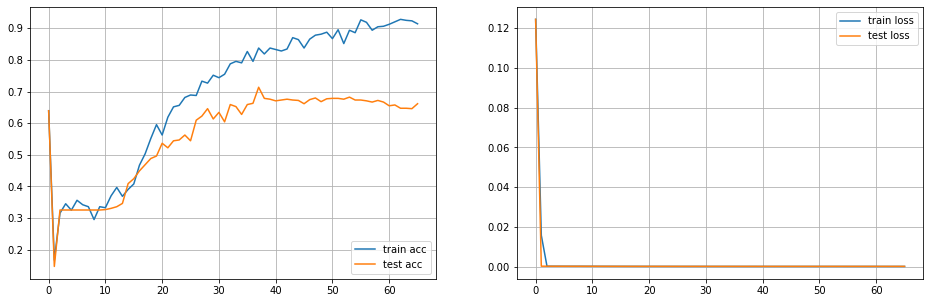

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss, accuracy: 5.4148517e-05, 0.9375 @ batch 652 (41728 samples) complete.                  

KeyboardInterrupt: 

In [16]:
print(gc.collect())
iterate_training()

In [17]:
# Load best model (checkpoint)
pt.cuda.empty_cache()
gc.collect()
cpoint = pt.load("./models/" + model_name + '/' + model_name)
# cpoint = pt.load("./models/" + 'ernst_one - 2k ts' + "/" + model_name)
# cpoint = pt.load("./models/" + 'ernst_one - 3k ts' + "/" + model_name)  # ~3000 training samples observed has current optimum
# cpoint = pt.load("./models/" + 'ernst_one - 30k ts' + "/" + model_name)
model.load_state_dict(cpoint['model'])
bcewl_loss.load_state_dict(cpoint['bcewl_loss'])
optimizer.load_state_dict(cpoint['optimizer'])
scheduler.load_state_dict(cpoint['scheduler'])
# llayer.load_state_dict(cpoint['llayer'])

In [18]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < pt.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = pt.sort(logits, descending=True)
        cumulative_probs = pt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [19]:
padder = int(pad_token.detach().cpu().numpy())
def append_next_token(sent, top_k=-1, top_p=0.9, temperature=1.0, olen=None):
    print("k =", top_k, ", p =", top_p, ", temp =", temperature)
    global model
    if dev != "cpu": pt.cuda.empty_cache()
    model.eval()
    tokens = tokenizer.encode(sent)
    ou = tokens.copy()
    while len(tokens) < max_len:
        tokens += [padder]
    x = pt.tensor([tokens], device=d)
    logits = inference(x, pt.tensor([len(ou)], device=d))[0]
    logits /= temperature
    logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
    probs = F.softmax(logits, dim=0)
    token = pt.multinomial(probs, 1).detach().cpu().numpy()[0]
    ou += [token]
    prev_len = len(sent) if olen is None else olen
    sent_new = tokenizer.decode(ou)
    print(sent[:prev_len] + '➡' + sent_new[prev_len:])
    return sent_new

# Interactive generation

In [547]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
"reinterpretation, harmony, character progression, reading circle")
# "monolith, elevator effect, time loop, survival, desert resort, town watchman")
# "monolith, allegro, soundtrack, chord, classical, opera")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
olen = len(input_sentence)

In [559]:
input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.6, temperature=15.0, olen=olen)

k = 25 , p = 0.6 , temp = 15.0
 A list of types of element of drama and writing: attention, surprise, fourth wall, diversion, fate, silence, pace, cliffhanger, character progression, monologuereinterpretation,➡, reading circle, cliffhaft-style character progression


In [739]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
"watermelon juice, cherry juice, blackcurrant mixture, kava, orangeade, lemon juice, cherryade, cranberry juice")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
olen = len(input_sentence)

In [740]:
input_sentence = append_next_token(input_sentence, top_k=10, top_p=0.8, temperature=5.0, olen=olen)

k = 10 , p = 0.8 , temp = 5.0
A list of types of element of drama and writing: kava, lemonade, coffee, milkshakewatermelon juice, coke, orangeade, blackcurrant mixture, water, cherry juice, lemon juice, ➡ black


In [686]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
# "")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider, yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider" + \
# ", yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5pm: Using log_period=1 (max_len=96) reliably finds improvement, need more data and larger gpt2 (medium+)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " milk, vodka, beer, ice water, soda, lassi, juice, alcohol, whiskey")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=2.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " wine, soda, alcohol, beer, liquor, apple cider, whiskey, milk, bourbon, vodka, cider, lemon juice")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:6])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=3.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " beer, milk, juice, wine, spirits, alcohol, soda, whiskey, brandy, apple juice, liquor, ice tea, watermelon juice, vodka," + \
# " lemon tea, apple cider, ale, lager, fruit tea, lime cider, cocktail, mocha, red wine, apple soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5am: lr=1e-5, max_len=80, log_period_batches=5 increased accuracy by 8%. Need to add a bunch more data

In [ ]:
# With about half an hour of fine-tuning using 5 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "soda, milk, juice, wine, vodka, gin, lime juice, beer, hot chocolate, cider, whiskey, fruit juice, cocktail, liquor, " + \
# "spirits, watermelon juice, martini, rum, chocolate milk, orangeade")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Without fine tuning (regular GPT-2):
# Initial input words on first line, those eventually found by repeatedly querying model on 2nd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, juice, fruit juice, soda, wine, beer, hot chocolate, chocolate milk, alcohol, cider, ice tea, liquor, spirit")
# input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89, olen=olen) # k = 25 also used

In [ ]:
# Training for too long (in this case ~6:30 hours) overfits
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "beer, juice, soda, liquor, wine, tequila, spirits, alcohol, cocktail, martini, whiskey, rum, vodka")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Changelog 15/04/2021 11am: Found learning rate 1e-7, max_listlen 15, min_nw 0.7, max_nw 0.9, lidstone_e 0.01 ACTUALLY WORKS

In [ ]:
# No fine tuning (testing gpt2) (old append function):
# input_sentence = "A list of types of drink: coffee, water, tea, coke, lemonade, milkshake"
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89)
# A list of types of drink: juice, tea, cider, lemonade, milk, beer, hot chocolate,➡ ice cold milk. Image

Working (reproducible) examples using various non-fine-tuned models:

In [ ]:
# GPT3 (via AI Dungeon) (Randomness = 2.0, model = Dragon):
# sentence = "A list of ML algorithms: inverse reinforcement learning, ELMo, decision tree, LDA, "
# expected_completion = "MLP, MLL, MMM. You can't believe you're actually using these things!"

# sentence = "A list of animals seen in the wild: wolffish, woodlouse, sheep, zebra, yak, "
# expected_completion = "goat, fox, dog, rat. You're guessing that a lot of other animals have been seen as well; maybe even all the animals on your list except for wolf and rat?"

In [ ]:
# GPT2 (via Write with Transformer) (Top-p = 0.67, temperature = 1.89, max time = 1.9):
# sentence = "A list of round fruits: peach, apricot, lime, plum, blackberry, cantaloupe, nectarine, pitaya, persimmon, "
# expected_completion = "mango, papaya and raspberry, as also many"

# sentence = "A list of chemical elements: hydrogen, carbon, oxygen, nitrogen, gold, "
# expected_completion = "silver, aluminum, potassium and phosphorus; atomic number."

# sentence = "A list of microbes found on earth: bacteria, virus, prokaryote, amoeba, "
# expected_completion = "archaea, algae, nematode, euk"